In [1]:
#| code-fold: true
#| warning: false
#| error: false
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import os

os.chdir("/project/persistent-exclusion-process/")

import gc

import numpy as np
import h5py
import glob
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from src.training_utils import (
    extract_floats,
    data_load,
    split_dataset,
    predict_multi_by_name,
    predict_and_plot,
    plot_violin_and_statistics
)
from src.models import make_net
from src.plot_utils import get_plot_configs

plot_configs = get_plot_configs()
plot_configs["axes.facecolor"] = [0.96, 0.96, 0.96, 1]
plot_configs["figure.facecolor"] = [0.98, 0.98, 0.98, 1]
plt.rcParams.update(plot_configs)

np.set_printoptions(precision=3, suppress=True)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(gpu_devices)

2024-03-15 02:02:26.694461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 02:02:27.536807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#| code-fold: true
tumbles = np.logspace(-6, -1, 10, base=2) # here are all the alphas available

x,y,shape = data_load(alphas=tumbles, densities=[0.25], orientation=True)
x_train, y_train, x_val, y_val = split_dataset(x,y,last=int(len(x)*0.2))
del x
del y
gc.collect()

Number of unique alpha:  10
Shape of x:  (30000, 128, 128, 1)
Shape of y:  (30000,)
Size of training data:  24000
Size of validation data:  6000


0

# Orientation 1 (helicopter1822)

In [3]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(1822)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

2024-03-08 18:18:53.879127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4776 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


In [4]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-08 18:18:57.887843: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-08 18:18:58.470608: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45


2024-03-08 18:18:59.341558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-03-08 18:18:59.713993: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x79c664709e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-08 18:18:59.714021: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-08 18:18:59.941484: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 - 5s - loss: 0.0558 - mae: 0.0558 - val_loss: 0.3219 - val_mae: 0.3219 - 5s/epoch - 14ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0674 - val_mae: 0.0674 - 3s/epoch - 7ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0214 - val_mae: 0.0214 - 3s/epoch - 7ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0207 - val_mae: 0.0207 - 3s/epoch - 7ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0272 - val_mae: 0.0272 - 3s/epoch - 7ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0522 - val_mae: 0.0522 - 3s/epoch - 7ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0242 - val_mae: 0.0242 - 3s/epoch - 7ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0183 - val_mae: 0.0183 - 3s/epoch - 7ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0280 - val_mae: 0.0280 - 3s/epoch - 7ms/step
Ep

Text(0.5, 1.0, 'Training and Validation MAE')

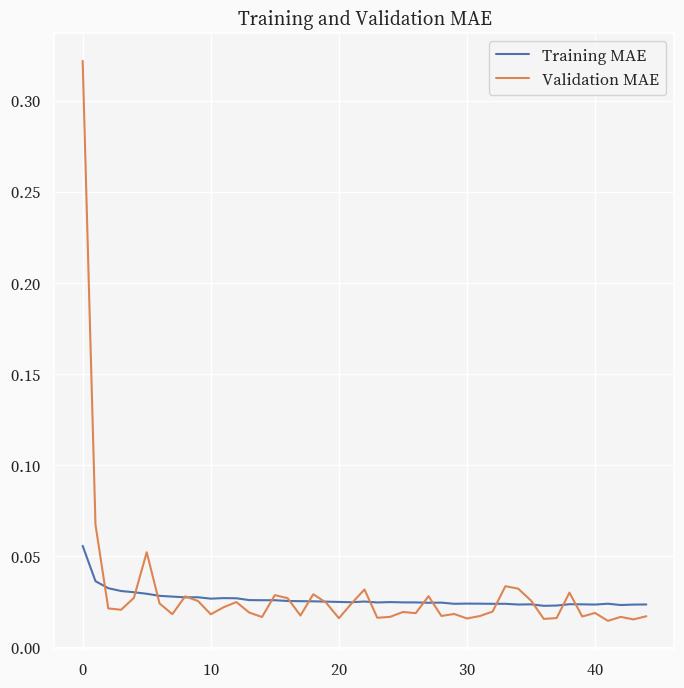

In [19]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 1s 2ms/step
Overlap ratio: 0.9
(Min, Max, Avg) STD: 3.7252903e-09 0.035443656 0.013694117
Pearson's correlation coeff:  0.9879729864534484
Overlap ratio: 0.9
(Min, Max, Avg) STD: 3.7252903e-09 0.035443656 0.013694117
Pearson's correlation coeff:  0.9879729864534484


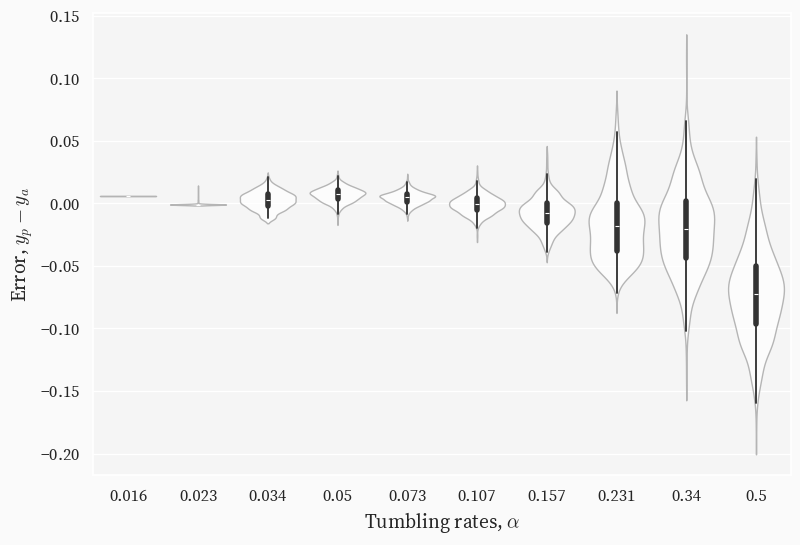

In [10]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [13]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "helicopter1822"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [14]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  12361


# Orientation 2 (wardrobe9539)

In [15]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(9539)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [16]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-08 18:24:29.619781: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-08 18:24:30.110301: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45
375/375 - 4s - loss: 0.0615 - mae: 0.0615 - val_loss: 0.2719 - val_mae: 0.2719 - 4s/epoch - 10ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0411 - mae: 0.0411 - val_loss: 0.0386 - val_mae: 0.0386 - 3s/epoch - 7ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0249 - val_mae: 0.0249 - 3s/epoch - 7ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0250 - val_mae: 0.0250 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0258 - val_mae: 0.0258 - 3s/epoch - 7ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0217 - val_mae: 0.0217 - 3s/epoch - 7ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0242 - val_mae: 0.0242 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0227 - val_mae: 0.0227 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0221 - val_mae: 0.0221 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

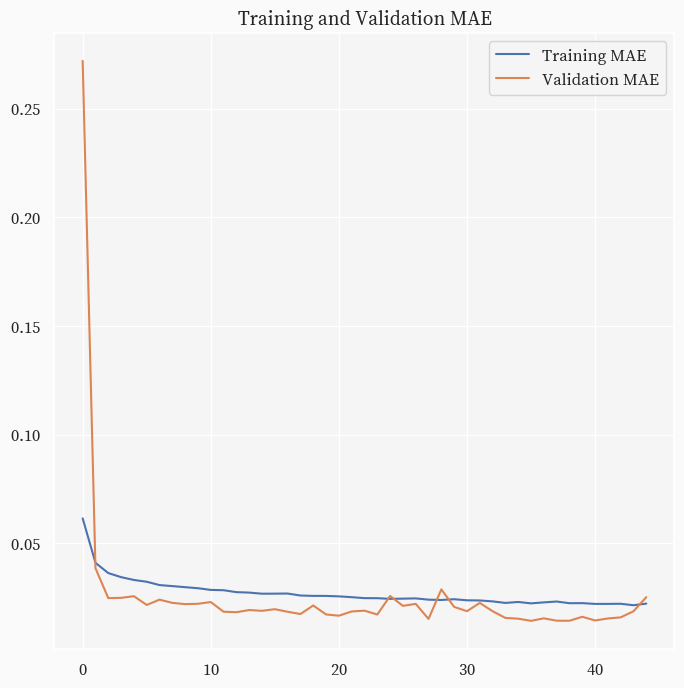

In [17]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.7
(Min, Max, Avg) STD: 0.0035856916 0.050546754 0.016456759
Pearson's correlation coeff:  0.9840812882274896
Overlap ratio: 0.7
(Min, Max, Avg) STD: 0.0035856916 0.050546754 0.016456759
Pearson's correlation coeff:  0.9840812882274896


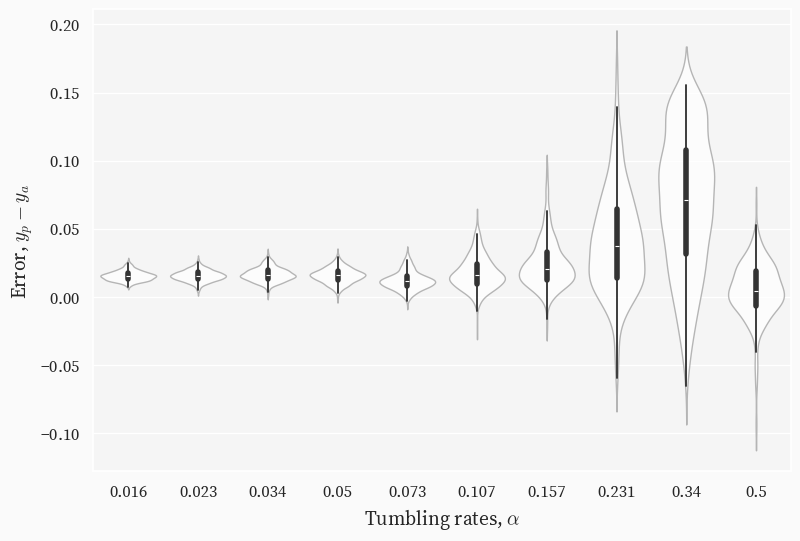

In [18]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [20]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "wardrobe9539"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [19]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  6374


# Orientation 3 (looper2409)

In [20]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(2409)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [21]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-08 18:29:24.877922: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45
375/375 - 4s - loss: 0.0466 - mae: 0.0466 - val_loss: 0.0793 - val_mae: 0.0793 - 4s/epoch - 10ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0391 - mae: 0.0391 - val_loss: 0.0325 - val_mae: 0.0325 - 3s/epoch - 7ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0286 - val_mae: 0.0286 - 3s/epoch - 7ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0295 - val_mae: 0.0295 - 3s/epoch - 7ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0247 - val_mae: 0.0247 - 3s/epoch - 7ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0320 - val_mae: 0.0320 - 3s/epoch - 7ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0243 - val_mae: 0.0243 - 3s/epoch - 7ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0223 - val_mae: 0.0223 - 3s/epoch - 7ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0223 - val_mae: 0.0223 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

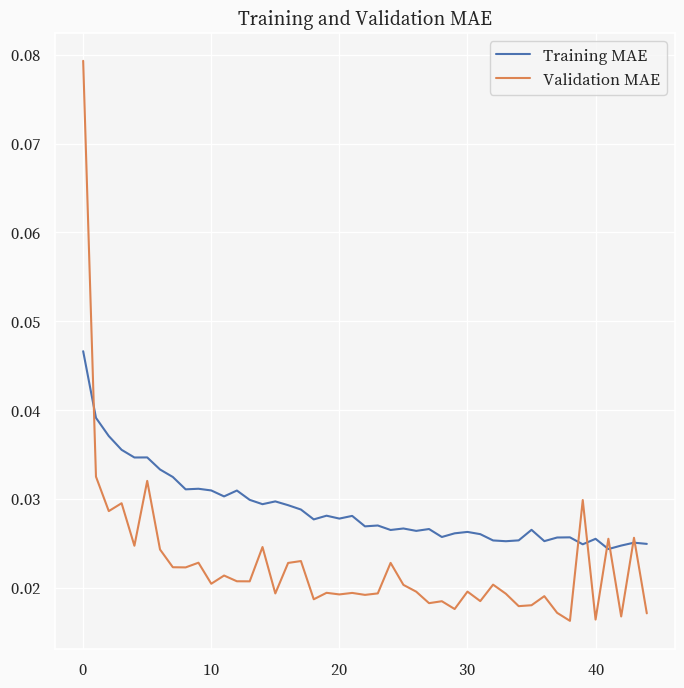

In [17]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.8
(Min, Max, Avg) STD: 1.8626451e-09 0.041631337 0.015631916
Pearson's correlation coeff:  0.9835614123165086
Overlap ratio: 0.8
(Min, Max, Avg) STD: 1.8626451e-09 0.041631337 0.015631916
Pearson's correlation coeff:  0.9835614123165086


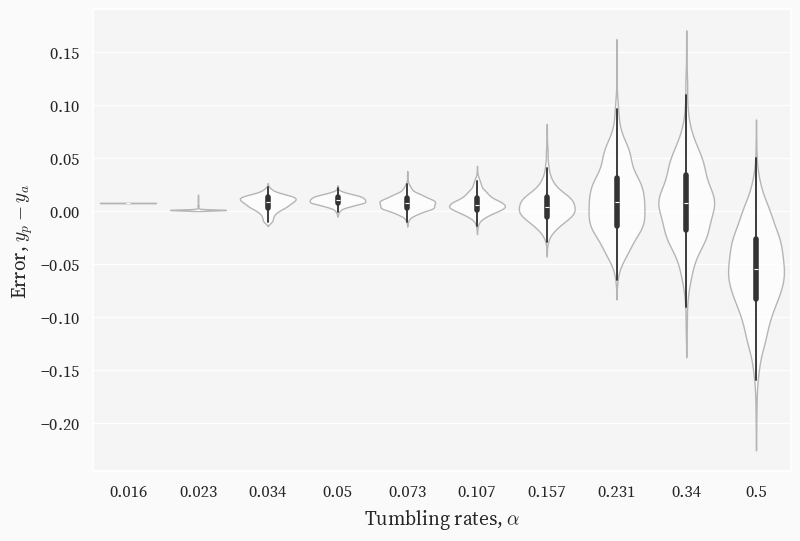

In [23]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [24]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "looper2409"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [25]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  21260


# Orientation 4 (potato8290)

In [3]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(8290)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

2024-03-13 19:56:55.931341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4298 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


In [4]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-13 19:57:09.294943: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-13 19:57:11.072638: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45


2024-03-13 19:57:11.974587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906


2024-03-13 19:57:12.362242: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7fbc709ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 19:57:12.362272: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5


2024-03-13 19:57:12.633620: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2024-03-13 19:57:16.138751: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.
2024-03-13 19:57:16.228392: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.


375/375 - 6s - loss: 0.0419 - mae: 0.0419 - val_loss: 0.3100 - val_mae: 0.3100 - 6s/epoch - 15ms/step


Epoch 2/45


375/375 - 3s - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0255 - val_mae: 0.0255 - 3s/epoch - 8ms/step


Epoch 3/45


375/375 - 3s - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0237 - val_mae: 0.0237 - 3s/epoch - 8ms/step


Epoch 4/45


375/375 - 3s - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0262 - val_mae: 0.0262 - 3s/epoch - 8ms/step


Epoch 5/45


375/375 - 3s - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0264 - val_mae: 0.0264 - 3s/epoch - 8ms/step


Epoch 6/45


375/375 - 3s - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0335 - val_mae: 0.0335 - 3s/epoch - 8ms/step


Epoch 7/45


375/375 - 3s - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0207 - val_mae: 0.0207 - 3s/epoch - 8ms/step


Epoch 8/45


375/375 - 3s - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0218 - val_mae: 0.0218 - 3s/epoch - 8ms/step


Epoch 9/45


375/375 - 3s - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0213 - val_mae: 0.0213 - 3s/epoch - 8ms/step


Epoch 10/45


375/375 - 3s - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0260 - val_mae: 0.0260 - 3s/epoch - 8ms/step


Epoch 11/45


375/375 - 3s - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0234 - val_mae: 0.0234 - 3s/epoch - 8ms/step


Epoch 12/45


375/375 - 3s - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0226 - val_mae: 0.0226 - 3s/epoch - 8ms/step


Epoch 13/45


375/375 - 3s - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0289 - val_mae: 0.0289 - 3s/epoch - 8ms/step


Epoch 14/45


375/375 - 3s - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0205 - val_mae: 0.0205 - 3s/epoch - 8ms/step


Epoch 15/45


375/375 - 3s - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0319 - val_mae: 0.0319 - 3s/epoch - 8ms/step


Epoch 16/45


375/375 - 3s - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0230 - val_mae: 0.0230 - 3s/epoch - 8ms/step


Epoch 17/45


375/375 - 3s - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0352 - val_mae: 0.0352 - 3s/epoch - 8ms/step


Epoch 18/45


375/375 - 3s - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0239 - val_mae: 0.0239 - 3s/epoch - 8ms/step


Epoch 19/45


375/375 - 3s - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0212 - val_mae: 0.0212 - 3s/epoch - 8ms/step


Epoch 20/45


375/375 - 3s - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0352 - val_mae: 0.0352 - 3s/epoch - 8ms/step


Epoch 21/45


375/375 - 3s - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0227 - val_mae: 0.0227 - 3s/epoch - 8ms/step


Epoch 22/45


375/375 - 3s - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0266 - val_mae: 0.0266 - 3s/epoch - 8ms/step


Epoch 23/45


375/375 - 3s - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0193 - val_mae: 0.0193 - 3s/epoch - 8ms/step


Epoch 24/45


375/375 - 3s - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0181 - val_mae: 0.0181 - 3s/epoch - 8ms/step


Epoch 25/45


375/375 - 3s - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0191 - val_mae: 0.0191 - 3s/epoch - 8ms/step


Epoch 26/45


375/375 - 3s - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0240 - val_mae: 0.0240 - 3s/epoch - 8ms/step


Epoch 27/45


375/375 - 3s - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0243 - val_mae: 0.0243 - 3s/epoch - 8ms/step


Epoch 28/45


375/375 - 3s - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0200 - val_mae: 0.0200 - 3s/epoch - 8ms/step


Epoch 29/45


375/375 - 3s - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0179 - val_mae: 0.0179 - 3s/epoch - 8ms/step


Epoch 30/45


375/375 - 3s - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0208 - val_mae: 0.0208 - 3s/epoch - 8ms/step


Epoch 31/45


375/375 - 3s - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0190 - val_mae: 0.0190 - 3s/epoch - 8ms/step


Epoch 32/45


375/375 - 3s - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0181 - val_mae: 0.0181 - 3s/epoch - 8ms/step


Epoch 33/45


375/375 - 3s - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0169 - val_mae: 0.0169 - 3s/epoch - 8ms/step


Epoch 34/45


375/375 - 3s - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0194 - val_mae: 0.0194 - 3s/epoch - 8ms/step


Epoch 35/45


375/375 - 3s - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0203 - val_mae: 0.0203 - 3s/epoch - 8ms/step


Epoch 36/45


375/375 - 3s - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0188 - val_mae: 0.0188 - 3s/epoch - 8ms/step


Epoch 37/45


375/375 - 3s - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0181 - val_mae: 0.0181 - 3s/epoch - 8ms/step


Epoch 38/45


375/375 - 3s - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0207 - val_mae: 0.0207 - 3s/epoch - 8ms/step


Epoch 39/45


375/375 - 3s - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0267 - val_mae: 0.0267 - 3s/epoch - 8ms/step


Epoch 40/45


375/375 - 3s - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0183 - val_mae: 0.0183 - 3s/epoch - 8ms/step


Epoch 41/45


375/375 - 3s - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0186 - val_mae: 0.0186 - 3s/epoch - 8ms/step


Epoch 42/45


375/375 - 3s - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0255 - val_mae: 0.0255 - 3s/epoch - 8ms/step


Epoch 43/45


375/375 - 3s - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0184 - val_mae: 0.0184 - 3s/epoch - 8ms/step


Epoch 44/45


375/375 - 3s - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0258 - val_mae: 0.0258 - 3s/epoch - 8ms/step


Epoch 45/45


375/375 - 3s - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0191 - val_mae: 0.0191 - 3s/epoch - 8ms/step


Evaluate on test data:


2024-03-13 19:59:22.114065: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.


Test loss: [0.01909952610731125, 0.01909952610731125]


Text(0.5, 1.0, 'Training and Validation MAE')

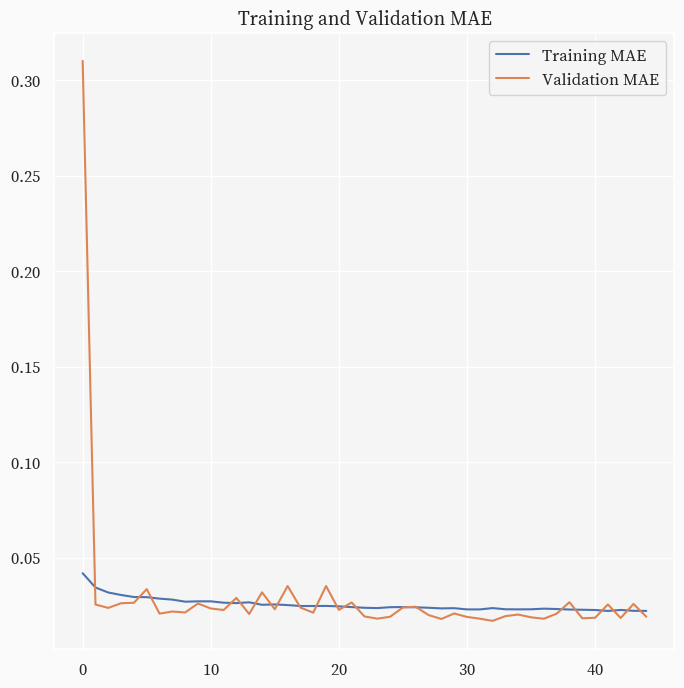

In [9]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

2024-03-14 19:14:25.387047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4359 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5
2024-03-14 19:14:25.914340: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.
2024-03-14 19:14:26.029183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.
2024-03-14 19:14:26.283084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906


188/188 [==============================] - 1s 2ms/step
Overlap ratio: 0.9
(Min, Max, Avg) STD: 0.0 0.03791279 0.014297364
Pearson's correlation coeff:  0.9858981253329838


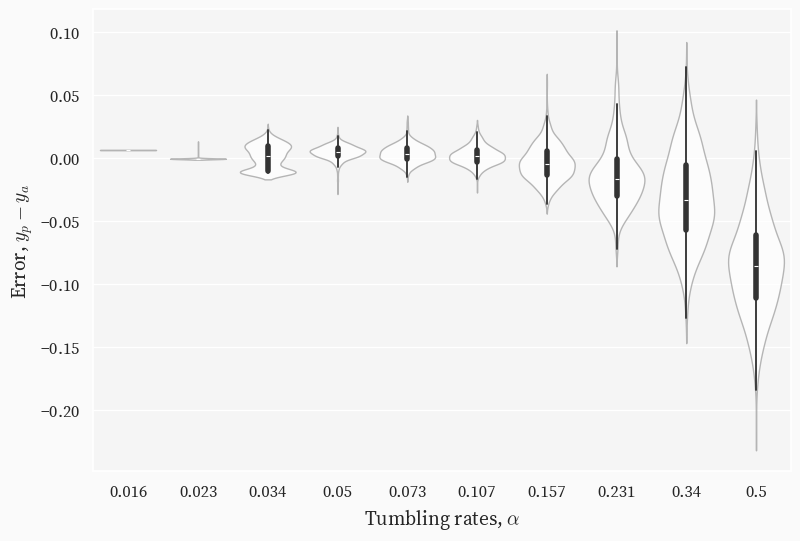

In [6]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [6]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "potato8290"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [ ]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

# Orientation 5 (cells9177)

In [9]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(9177)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [10]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

Epoch 1/45


2024-03-14 19:17:10.726420: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x72ec40a15fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 19:17:10.726448: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-14 19:17:10.969269: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 - 5s - loss: 0.0513 - mae: 0.0513 - val_loss: 0.1914 - val_mae: 0.1914 - 5s/epoch - 13ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0286 - val_mae: 0.0286 - 3s/epoch - 7ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0240 - val_mae: 0.0240 - 3s/epoch - 7ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0249 - val_mae: 0.0249 - 3s/epoch - 7ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0247 - val_mae: 0.0247 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0221 - val_mae: 0.0221 - 3s/epoch - 7ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0214 - val_mae: 0.0214 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0223 - val_mae: 0.0223 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0201 - val_mae: 0.0201 - 3s/epoch - 7ms/step
Ep

Text(0.5, 1.0, 'Training and Validation MAE')

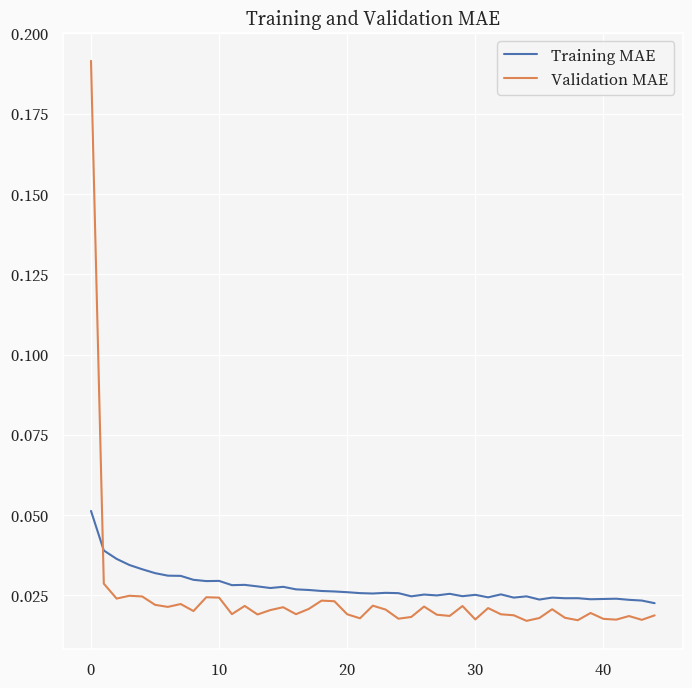

In [11]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 1.0
(Min, Max, Avg) STD: 0.0028894818 0.038020052 0.014290817
Pearson's correlation coeff:  0.9859140616409121


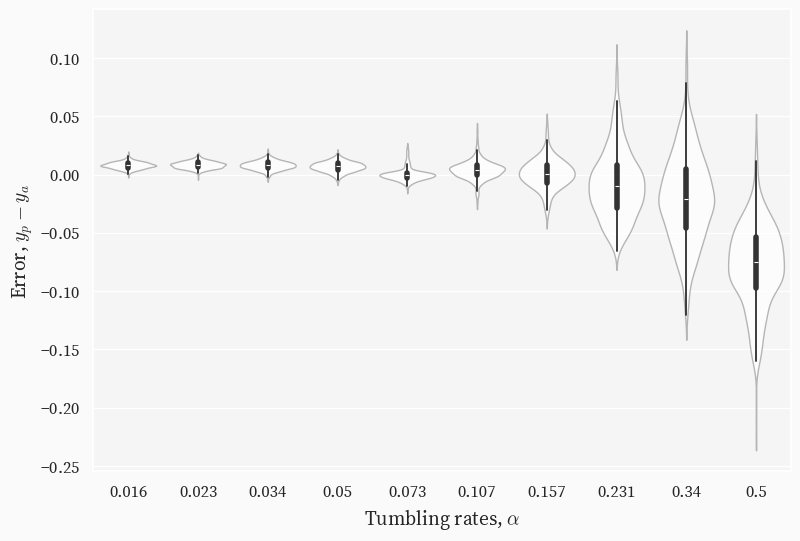

In [12]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [13]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "cells9177"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [16]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  46099


# Orientation 6 (hyphen1065)

In [17]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(1065)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [18]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

Epoch 1/45
375/375 - 4s - loss: 0.0862 - mae: 0.0862 - val_loss: 0.1584 - val_mae: 0.1584 - 4s/epoch - 11ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0642 - mae: 0.0642 - val_loss: 0.0471 - val_mae: 0.0471 - 3s/epoch - 8ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0563 - mae: 0.0563 - val_loss: 0.0425 - val_mae: 0.0425 - 3s/epoch - 8ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0506 - mae: 0.0506 - val_loss: 0.0367 - val_mae: 0.0367 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0464 - mae: 0.0464 - val_loss: 0.0312 - val_mae: 0.0312 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0439 - mae: 0.0439 - val_loss: 0.0288 - val_mae: 0.0288 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0261 - val_mae: 0.0261 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0407 - mae: 0.0407 - val_loss: 0.0298 - val_mae: 0.0298 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0262 - val_mae: 0.0262 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

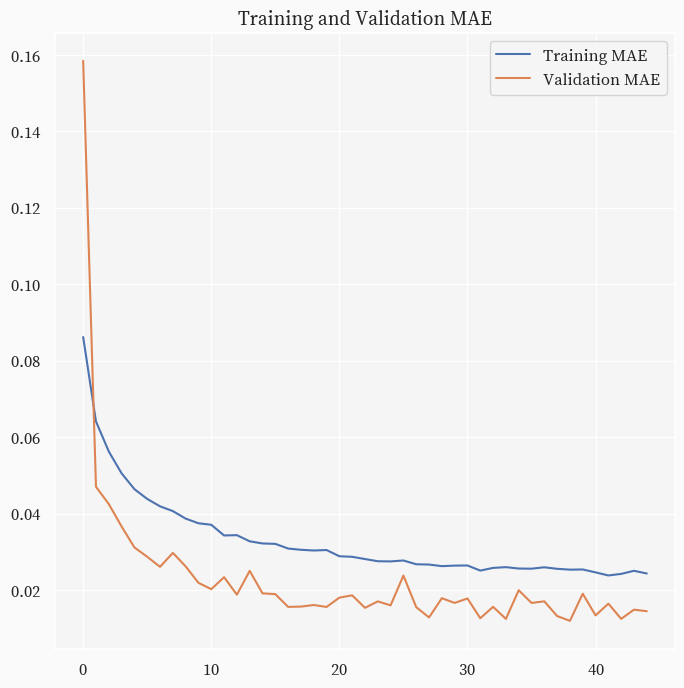

In [19]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.9
(Min, Max, Avg) STD: 0.0022716527 0.042106934 0.014879532
Pearson's correlation coeff:  0.9890752118465276


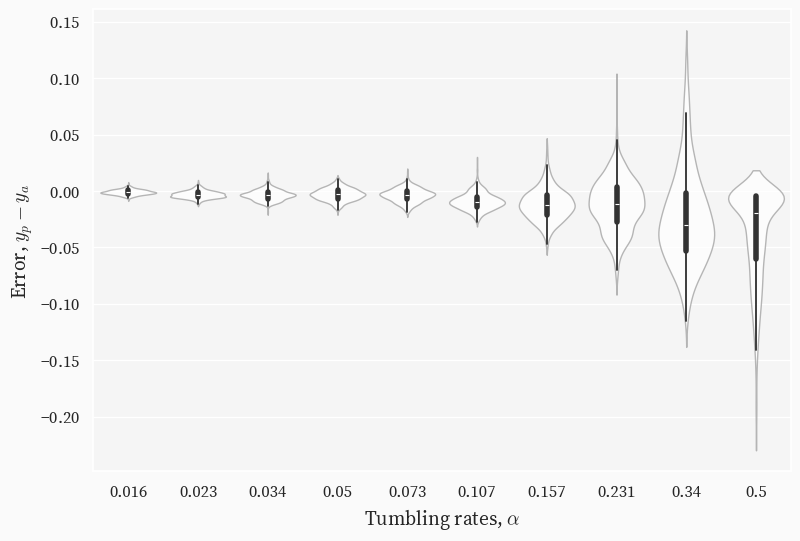

In [20]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [21]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "hyphen1065"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [23]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  23924


# Orientation 7 (playground6730)

In [31]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(6730)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [32]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

Epoch 1/45
375/375 - 4s - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0886 - val_mae: 0.0886 - 4s/epoch - 10ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0392 - mae: 0.0392 - val_loss: 0.0284 - val_mae: 0.0284 - 3s/epoch - 8ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0261 - val_mae: 0.0261 - 3s/epoch - 8ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0248 - val_mae: 0.0248 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0264 - val_mae: 0.0264 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0225 - val_mae: 0.0225 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0237 - val_mae: 0.0237 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0223 - val_mae: 0.0223 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0216 - val_mae: 0.0216 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

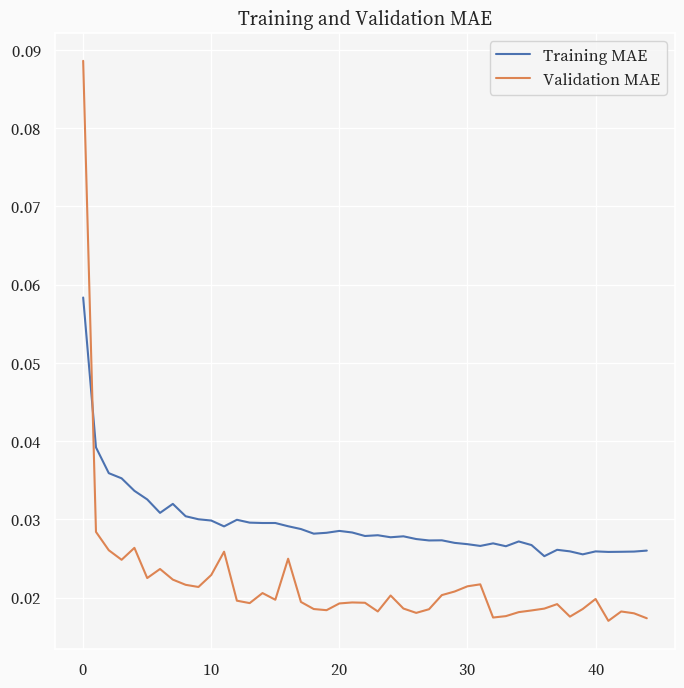

In [33]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.9
(Min, Max, Avg) STD: 1.8626451e-09 0.036786065 0.015013708
Pearson's correlation coeff:  0.9823049385577914


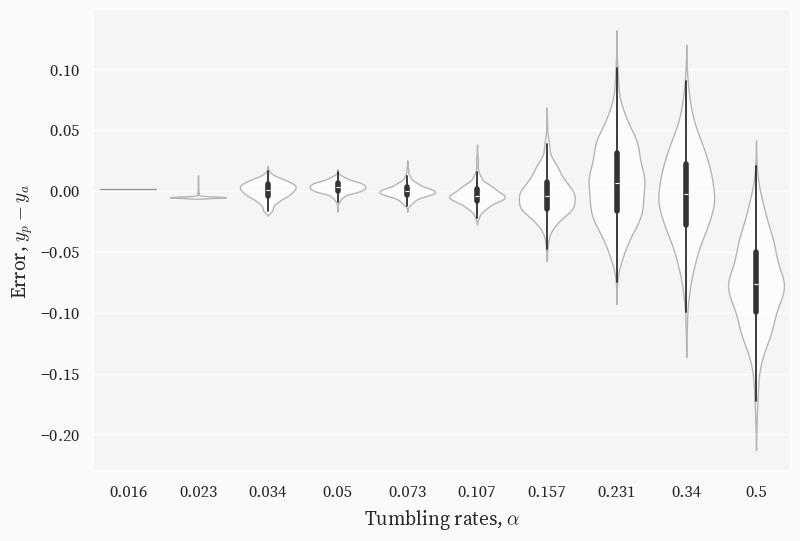

In [34]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [35]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "playground6730"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [36]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  22022


# Summary

In [3]:
#| code-fold: true
#| warning: false
#| error: false
#| output: false

model_names = [
    "helicopter1822",
    "wardrobe9539",
    "looper2409",
    "potato8290",
    "cells9177",
    "hyphen1065",
    "playground6730",
]
predictions, actual = predict_multi_by_name(model_names, x_val, y_val)

2024-03-15 02:02:52.810734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4261 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5
2024-03-15 02:02:53.197726: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.
2024-03-15 02:02:53.306938: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.
2024-03-15 02:02:53.527706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-03-15 02:02:54.647629: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.
2024-03-15 02:02:54.741607: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 393216000 exceeds 10% of free system memory.
2024-03-15 02:02:55.533883: W tensorflow/tsl/framework/cpu_a

Overlap ratio: 1.0
(Min, Max, Avg) STD: 0.0038245448 0.04241791 0.01668973
Pearson's correlation coeff:  0.9849222243958358


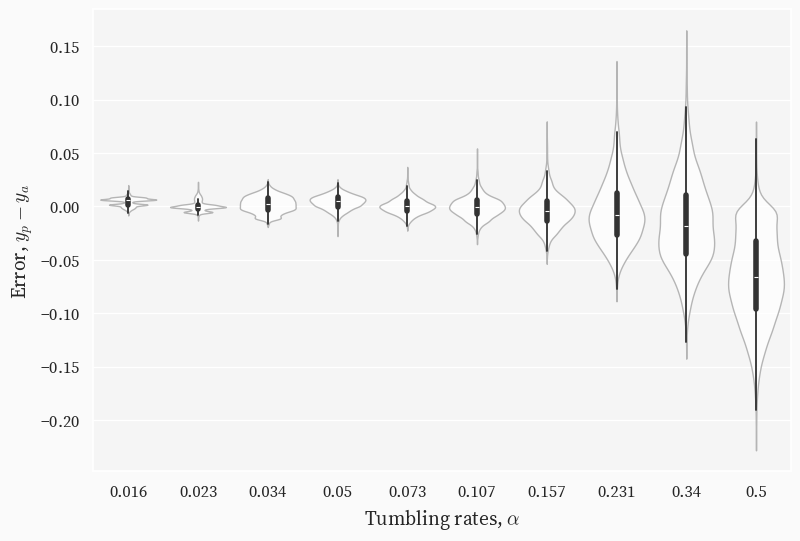

In [4]:
#| code-fold: true
#| warning: false
#| error: false

plot_violin_and_statistics(predictions,actual)

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
df = pd.DataFrame()
df.insert(0, "predicted", predictions - actual)
df.insert(1, "actual", actual)

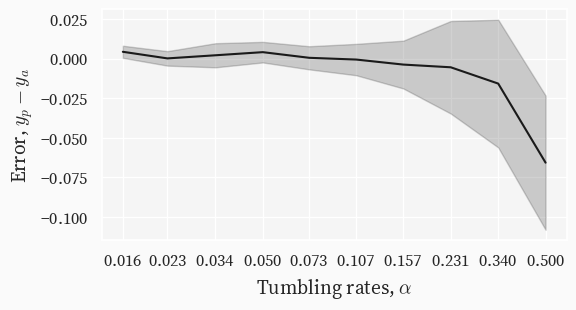

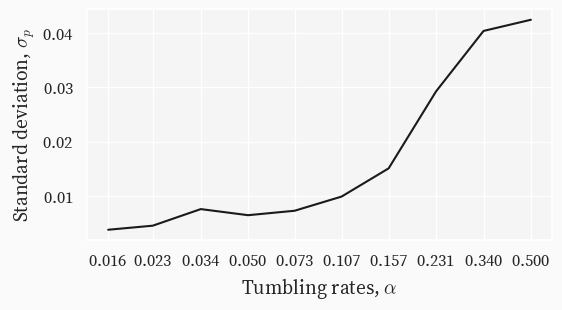

In [6]:
fig, ax = plt.subplots(figsize=(6,3))
sns.lineplot(ax=ax, data=df, x="actual", y="predicted", errorbar=("sd", 1), c='k')
ax.set(xlabel=r"Tumbling rates, $\alpha$", ylabel=r"Error, $y_p - y_a$")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(actual))
fig, ax = plt.subplots(figsize=(6,3))
sns.lineplot(c='k', ax=ax, x=np.unique(actual), y=df.groupby('actual', as_index=False)['predicted'].std()['predicted'])
ax.set(xlabel=r"Tumbling rates, $\alpha$", ylabel=r"Standard deviation, $\sigma_p$")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(actual))